## Objective:
Create relationship between the combined dataset that has lon and lat data and segments and/or water bodies. 

In [1]:
import geopandas as gpd
import pandas as pd
import fiona
# from ipyfilechooser import FileChooser
from geopandas import GeoSeries

import itertools
from operator import itemgetter

import numpy as np

from scipy.spatial import cKDTree

from shapely.geometry import Polygon, MultiPolygon, shape, Point, LineString
from pyproj import Proj


## Steps:
- Clean the data
- Convert lon and lot to Points
- Find the closest segment and water body to each study point
- Export the results as CSv for Neo4j

In [2]:
pt_df = pd.read_csv('data/Rubaba/labrador&waterquality_joined.csv')
pt_df.info()

/home/javad/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (2,3,4,9,10,11,12,29,30,31,32,33,34,37,38,39) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259800 entries, 0 to 259799
Data columns (total 49 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Effort_Id            259800 non-null  object 
 1   DataSetName          259800 non-null  object 
 2   SiteName             272 non-null     object 
 3   SiteCode             272 non-null     object 
 4   SiteId               272 non-null     object 
 5   Latitude             169 non-null     float64
 6   Longitude            169 non-null     float64
 7   Date                 259708 non-null  object 
 8   VolumeFIltered.L     64 non-null      float64
 9   Sample _Method       88 non-null      object 
 10  Filter size          88 non-null      object 
 11  PrimaryInvestigator  203 non-null     object 
 12  effort_type          203 non-null     object 
 13  Unnamed: 0           259528 non-null  float64
 14  SITE_NO              259528 non-null  object 
 15  FLAG_MARQUEUR    

## Cleaning
The file has two sets of lon and lat.  Also some geao data are missing:

In [3]:
pt_df[pt_df.Latitude.isna() & pt_df.LATITUDE.isna()].shape
# 103 rows don't have any geo data

(103, 49)

## Merge two geo data

In [4]:
# merge the two geo data column:
pt_df['LATITUDE'].fillna(pt_df['Latitude'], inplace=True)
pt_df['LONGITUDE'].fillna(pt_df['Longitude'], inplace=True)
pt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259800 entries, 0 to 259799
Data columns (total 49 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Effort_Id            259800 non-null  object 
 1   DataSetName          259800 non-null  object 
 2   SiteName             272 non-null     object 
 3   SiteCode             272 non-null     object 
 4   SiteId               272 non-null     object 
 5   Latitude             169 non-null     float64
 6   Longitude            169 non-null     float64
 7   Date                 259708 non-null  object 
 8   VolumeFIltered.L     64 non-null      float64
 9   Sample _Method       88 non-null      object 
 10  Filter size          88 non-null      object 
 11  PrimaryInvestigator  203 non-null     object 
 12  effort_type          203 non-null     object 
 13  Unnamed: 0           259528 non-null  float64
 14  SITE_NO              259528 non-null  object 
 15  FLAG_MARQUEUR    

In [5]:
# drop the row if no geo data is in the row
pt_df.dropna(subset=['LATITUDE'], inplace=True)

In [6]:
# create points
pt_df = gpd.GeoDataFrame(
    pt_df, geometry=gpd.points_from_xy(pt_df.LONGITUDE, pt_df.LATITUDE), crs="EPSG:4326")# crs of waterbodies is 4326

<AxesSubplot:>

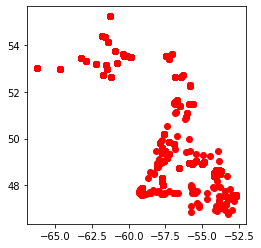

In [7]:
pt_df.plot(color='red')

## Points location and segments relationship
Find the closest segment to each point

<AxesSubplot:>

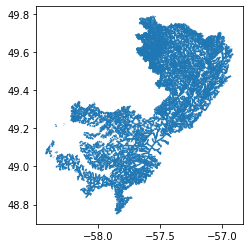

In [8]:
fl_df = gpd.read_file('data/NHN/NHN_02YL000_3_1_HN_NLFLOW_1.shp')
fl_df.plot()

# Flatten the geo data:
Data from open Canada is 3d, i.e. has a Z component. convert to 2d:

<AxesSubplot:>

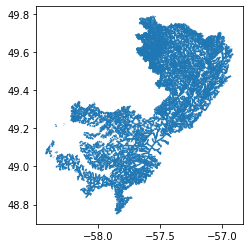

In [9]:

def ddd_to_dd_line(g):
    return LineString([xy[0:2] for xy in list(g.coords)]) 

fl_df['geometry'] = fl_df.geometry.apply(lambda x: ddd_to_dd_line(x))
fl_df.plot() 


In [10]:

def ckdnearesl_line(gdfA, gdfB, gdfB_cols=[], utm_zone = 21):
    """ A is point and B is Linestring
        returns the closest line of gdfB to each point of gdfA and their distance in meters
    """
    gdfA = gdfA.reset_index(drop=True).copy()
    gdfB = gdfB.reset_index(drop=True).copy()
    A = np.concatenate(
        [np.array(geom.coords) for geom in gdfA.geometry.to_list()])
    B = [np.array(geom.coords) for geom in gdfB.geometry.to_list()]
    B = np.array(B)
    A = np.array(A)

    Ashape = A.shape
    
    pp = Proj(proj='utm',zone=utm_zone ,ellps='WGS84', preserve_units=False)

    A = np.array(pp(A[:,0].reshape(-1,1), A[:,1].reshape(-1,1))).transpose().reshape((-1,2))

    A = A.reshape(Ashape)


    B_ix = tuple(itertools.chain.from_iterable(
        [itertools.repeat(i, x) for i, x in enumerate(list(map(len, B)))]))
    B = np.concatenate(B)
    Bshape = B.shape
    B = np.array(pp(B[:,0].reshape(-1,1), B[:,1].reshape(-1,1))).transpose().reshape(Bshape)


    ckd_tree = cKDTree(B)
    dist, idx = ckd_tree.query(A, k=1)

    idx = itemgetter(*idx)(B_ix) 


    gdf = pd.concat(
        [gdfA, gdfB.loc[idx, gdfB_cols].reset_index(drop=True),
         pd.Series(dist, name='dist-meters')], axis=1)
    return gdf


## Creating segment ID
As the ids are not consistent, we use the row number and the DATASETNAME to create an ID for each row.

In [12]:
fl_df['row_index'] = fl_df.index
fl_df['row_index'] = fl_df['row_index'].astype('str')
fl_df['segment_id'] = fl_df['DATASETNAM'] + "-" + fl_df.row_index

# Finding the closest segment to each point:

The data is geographic and has lon and lat. To get the distances in meter, we need to project it onto a map. Use this site to find the UTM zone and pass that to the next function. https://mangomap.com/robertyoung/maps/69585/what-utm-zone-am-i-in-#

In [13]:
# columns to keep from segment dataframe:
fl_cols = ['segment_id'] 

UTM_ZONE = 21 # most of Newfoundland is in this zone 

pt_fl_nearept_df = ckdnearesl_line(pt_df, fl_df, fl_cols, utm_zone= UTM_ZONE )

<ipython-input-10-dc5d58cbd102>:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  B = np.array(B)


### Sort by distance:

In [14]:
pt_fl_nearept_df.sort_values('dist-meters')


,Effort_Id,DataSetName,SiteName,SiteCode,SiteId,Latitude,Longitude,Date,VolumeFIltered.L,Sample _Method,...,DOmg.L,DO.CH,Sal,C.us.-cm,pH,pH.mV,ORP,geometry,segment_id,dist-meters
34508,wqnl34509,WaterQualityNL,NaN,NaN,NaN,NaN,NaN,2017-05-17,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-57.76110 48.98360),02YL000-27252,10.922409
34459,wqnl34460,WaterQualityNL,NaN,NaN,NaN,NaN,NaN,2017-04-26,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-57.76110 48.98360),02YL000-27252,10.922409
34460,wqnl34461,WaterQualityNL,NaN,NaN,NaN,NaN,NaN,2017-04-26,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-57.76110 48.98360),02YL000-27252,10.922409
34461,wqnl34462,WaterQualityNL,NaN,NaN,NaN,NaN,NaN,2017-04-26,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-57.76110 48.98360),02YL000-27252,10.922409
34462,wqnl34463,WaterQualityNL,NaN,NaN,NaN,NaN,NaN,2017-04-26,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-57.76110 48.98360),02YL000-27252,10.922409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199986,wqnl199987,WaterQualityNL,NaN,NaN,NaN,NaN,NaN,2013-08-14,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-66.24162 53.00169),02YL000-6624,695542.544698
199985,wqnl199986,WaterQualityNL,NaN,NaN,NaN,NaN,NaN,2013-08-14,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-66.24162 53.00169),02YL000-6624,695542.544698
199984,wqnl199985,WaterQualityNL,NaN,NaN,NaN,NaN,NaN,2013-08-14,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-66.24162 53.00169),02YL000-6624,695542.544698
200014,wqnl200015,WaterQualityNL,NaN,NaN,NaN,NaN,NaN,2013-08-14,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-66.24162 53.00169),02YL000-6624,695542.544698


Points are matched with the closest segments to them. Segments are identified by segment_id. The distances between the points locations and the closest segments are stored in the `dist` column.

<AxesSubplot:>

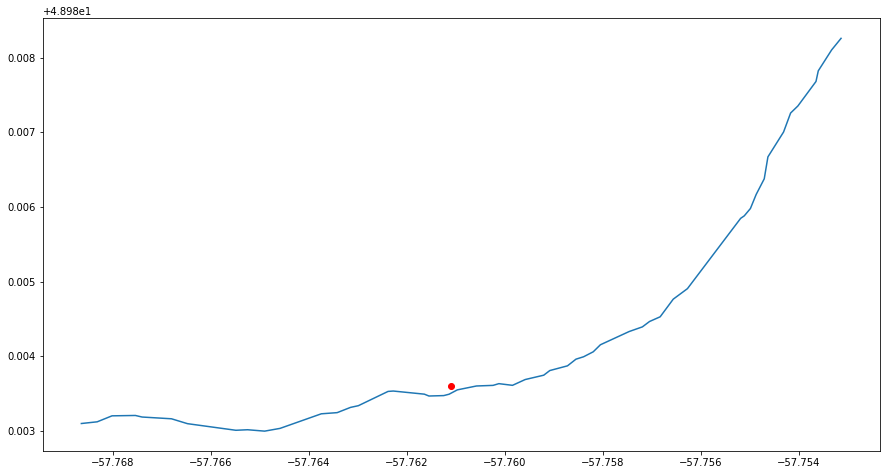

In [15]:
# plot one point and its closest segment

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,15))
ax.set_aspect('equal')
fl_df[fl_df['segment_id'] == '02YL000-27252'].plot(ax=ax)
pt_fl_nearept_df[pt_fl_nearept_df['Effort_Id'] =='wqnl34509'].plot(color='red', ax= ax)


## plot points and segments:

<AxesSubplot:>

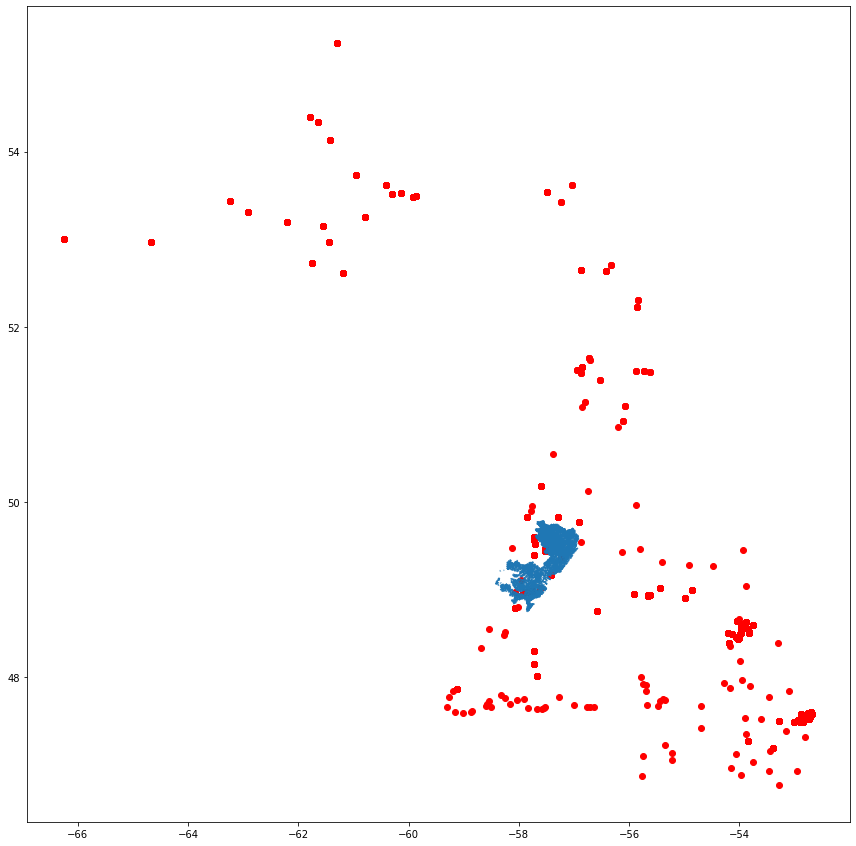

In [16]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,15))
ax.set_aspect('equal')
fl_df.plot(ax=ax)
pt_fl_nearept_df.plot(color='red', ax= ax)


# Segments are not covering:
As the plot shows, there are many points that are outside of the region covered by the segment file.
- Solution:
    - Filter out distant points
    - Import more segment data (For other regions)
     
     
### Segments and points that have a distance less than 200 meters:

(15785, 52)

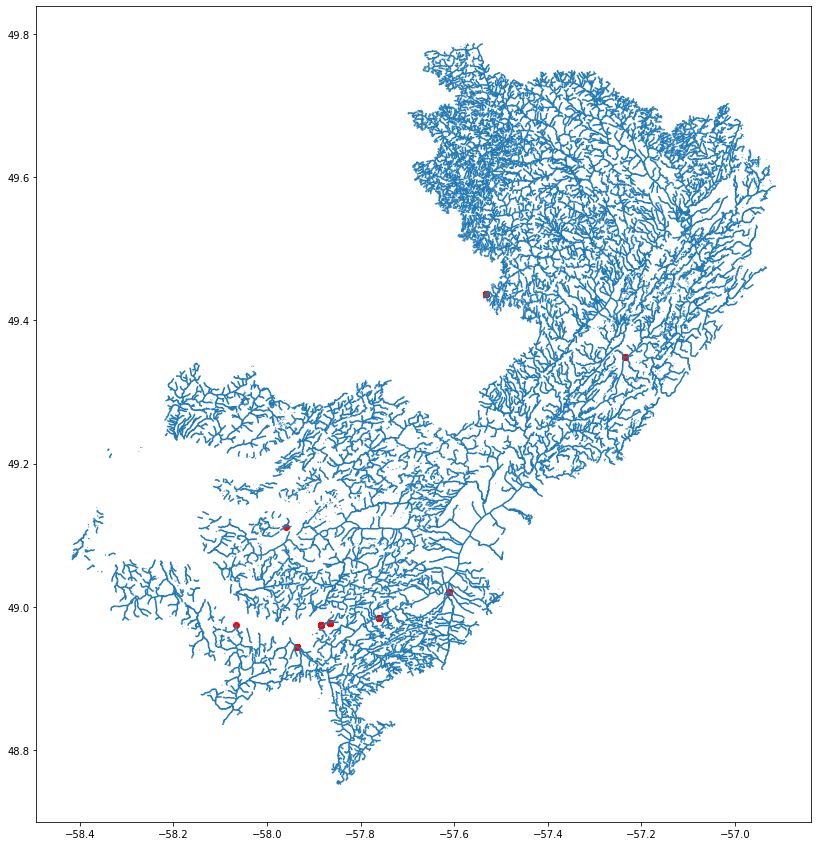

In [68]:
# plot points withing the segment region

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,15))
ax.set_aspect('equal')
fl_df.plot(ax=ax)
# pt_fl_nearept_df.iloc[0:5,:].plot(color='red', ax= ax)
pt_fl_nearept_df[pt_fl_nearept_df['dist-meters'] < 200].plot(color='red', ax= ax)
# fl_df.plot()
pt_fl_nearept_df[pt_fl_nearept_df['dist-meters'] < 200].shape

## Save :
- CSV for database import


In [18]:
pt_fl_nearept_df.to_csv('data/points_to_segments.csv', index=False)

## Study to water body connection:
Repeat the same process for water bodies dataset.

In [26]:
wb_df = gpd.read_file('data/NHN/NHN_02YL000_3_1_HD_WATERBODY_2.shp')

In [27]:
wb_df.head()

,NID,VALDATE,ACQTECH,DATASETNAM,ACCURACY,PROVIDER,METACOVER,DEFINITION,TYPE_TEXT,ISOLATED,...,LAKEID_2,RIVID_1,RIVID_2,LAKENAME_1,LAKENAME_2,RIVNAME_1,RIVNAME_2,IDDATE,NAMEDATE,geometry
0,70a0a6d6d46849318c3764b9830b2f18,1986,5,02YL000,10,2,1,4,Lake,0,...,None,None,None,None,None,None,None,None,None,"POLYGON Z ((-57.09482 49.60720 0.00000, -57.09..."
1,b0441903adea488d97e258b270722a4e,1986,5,02YL000,10,2,1,4,Lake,0,...,None,None,None,None,None,None,None,None,None,"POLYGON Z ((-57.73406 49.31636 0.00000, -57.73..."
2,85459965150947a99610efd9ca9cb087,1986,5,02YL000,10,2,1,4,Lake,0,...,None,None,None,None,None,None,None,None,None,"POLYGON Z ((-57.53319 49.68667 0.00000, -57.53..."
3,52b29208f2b04f2fa4e1c7d066f0ae1e,1986,5,02YL000,10,2,1,4,Lake,0,...,None,None,None,None,None,None,None,None,None,"POLYGON Z ((-57.54525 49.63484 0.00000, -57.54..."
4,8082fbdcaa81437ca046e4d3d5b30c04,1986,5,02YL000,10,2,1,4,Lake,0,...,None,None,None,None,None,None,None,None,None,"POLYGON Z ((-57.21786 49.61157 0.00000, -57.21..."


## Creating water body ID
Similar to segments, as the ids are not consistent, we use the row number and the DATASETNAME to create an ID for each row.

In [28]:
wb_df['row_index'] = wb_df.index
wb_df['row_index'] = wb_df['row_index'].astype('str')
wb_df['waterbody_id'] = wb_df['DATASETNAM'] + "-" + wb_df.row_index

In [29]:
wb_df.head()

,NID,VALDATE,ACQTECH,DATASETNAM,ACCURACY,PROVIDER,METACOVER,DEFINITION,TYPE_TEXT,ISOLATED,...,RIVID_2,LAKENAME_1,LAKENAME_2,RIVNAME_1,RIVNAME_2,IDDATE,NAMEDATE,geometry,row_index,waterbody_id
0,70a0a6d6d46849318c3764b9830b2f18,1986,5,02YL000,10,2,1,4,Lake,0,...,None,None,None,None,None,None,None,"POLYGON Z ((-57.09482 49.60720 0.00000, -57.09...",0,02YL000-0
1,b0441903adea488d97e258b270722a4e,1986,5,02YL000,10,2,1,4,Lake,0,...,None,None,None,None,None,None,None,"POLYGON Z ((-57.73406 49.31636 0.00000, -57.73...",1,02YL000-1
2,85459965150947a99610efd9ca9cb087,1986,5,02YL000,10,2,1,4,Lake,0,...,None,None,None,None,None,None,None,"POLYGON Z ((-57.53319 49.68667 0.00000, -57.53...",2,02YL000-2
3,52b29208f2b04f2fa4e1c7d066f0ae1e,1986,5,02YL000,10,2,1,4,Lake,0,...,None,None,None,None,None,None,None,"POLYGON Z ((-57.54525 49.63484 0.00000, -57.54...",3,02YL000-3
4,8082fbdcaa81437ca046e4d3d5b30c04,1986,5,02YL000,10,2,1,4,Lake,0,...,None,None,None,None,None,None,None,"POLYGON Z ((-57.21786 49.61157 0.00000, -57.21...",4,02YL000-4


In [41]:

def ckdnearesl_poly(gdfA, gdfB, gdfB_cols, utm_zone = 21):
    """ A is point and B is Polygon """
    gdfA = gdfA.reset_index(drop=True)
    gdfB = gdfB.reset_index(drop=True)
    A = np.concatenate(
        [np.array(geom.coords) for geom in gdfA.geometry.to_list()])
    B = [np.array(geom.coords) for geom in gdfB.exterior]

    B = np.array(B)
    A = np.array(A)

    Ashape = A.shape
    
    pp = Proj(proj='utm',zone=utm_zone ,ellps='WGS84', preserve_units=False)

    A = np.array(pp(A[:,0].reshape(-1,1), A[:,1].reshape(-1,1))).transpose().reshape((-1,2))

    A = A.reshape(Ashape)


    B_ix = tuple(itertools.chain.from_iterable(
        [itertools.repeat(i, x) for i, x in enumerate(list(map(len, B)))]))
    B = np.concatenate(B)
    Bshape = B.shape
    B = np.array(pp(B[:,0].reshape(-1,1), B[:,1].reshape(-1,1))).transpose().reshape(Bshape)


    ckd_tree = cKDTree(B)
    dist, idx = ckd_tree.query(A, k=1)

    idx = itemgetter(*idx)(B_ix) 


    gdf = pd.concat(
        [gdfA, gdfB.loc[idx, gdfB_cols].reset_index(drop=True),
         pd.Series(dist, name='dist-meters')], axis=1)
    return gdf


<AxesSubplot:>

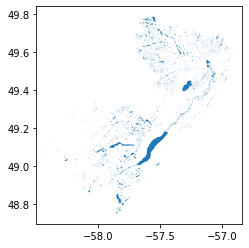

In [38]:
# same as segment, water body data from open canada needs to be 2d

def ddd_to_dd_poly(g):
    return Polygon([xy[0:2] for xy in list(g.exterior.coords)]) 

wb_df['geometry'] = wb_df.geometry.apply(lambda x: ddd_to_dd_poly(x))
wb_df.plot() 


In [44]:
# columns to keep from waterbody dataframe:
wb_cols = ['waterbody_id'] 
pt_wb_nearept_df = ckdnearesl_poly(pt_df, wb_df, wb_cols,utm_zone=UTM_ZONE)

<ipython-input-41-94e7e63047a9>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  B = np.array(B)


In [45]:
pt_wb_nearept_df.sort_values('dist-meters')

,Effort_Id,DataSetName,SiteName,SiteCode,SiteId,Latitude,Longitude,Date,VolumeFIltered.L,Sample _Method,...,DOmg.L,DO.CH,Sal,C.us.-cm,pH,pH.mV,ORP,geometry,waterbody_id,dist-meters
42635,wqnl42636,WaterQualityNL,NaN,NaN,NaN,NaN,NaN,2016-11-30,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-57.61177 49.02123),02YL000-7974,12.216385
42747,wqnl42748,WaterQualityNL,NaN,NaN,NaN,NaN,NaN,2017-05-24,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-57.61177 49.02123),02YL000-7974,12.216385
42746,wqnl42747,WaterQualityNL,NaN,NaN,NaN,NaN,NaN,2017-05-24,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-57.61177 49.02123),02YL000-7974,12.216385
42745,wqnl42746,WaterQualityNL,NaN,NaN,NaN,NaN,NaN,2017-05-24,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-57.61177 49.02123),02YL000-7974,12.216385
42744,wqnl42745,WaterQualityNL,NaN,NaN,NaN,NaN,NaN,2017-05-24,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-57.61177 49.02123),02YL000-7974,12.216385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199986,wqnl199987,WaterQualityNL,NaN,NaN,NaN,NaN,NaN,2013-08-14,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-66.24162 53.00169),02YL000-6768,696939.753342
199985,wqnl199986,WaterQualityNL,NaN,NaN,NaN,NaN,NaN,2013-08-14,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-66.24162 53.00169),02YL000-6768,696939.753342
199984,wqnl199985,WaterQualityNL,NaN,NaN,NaN,NaN,NaN,2013-08-14,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-66.24162 53.00169),02YL000-6768,696939.753342
200014,wqnl200015,WaterQualityNL,NaN,NaN,NaN,NaN,NaN,2013-08-14,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-66.24162 53.00169),02YL000-6768,696939.753342


## Save:
- CSV for database import

In [ ]:
sl_wb_nearept_df.to_csv('data/points-to-waterbodies/points_to_waterbodies.csv')